In [53]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [21]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [11]:


dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [14]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


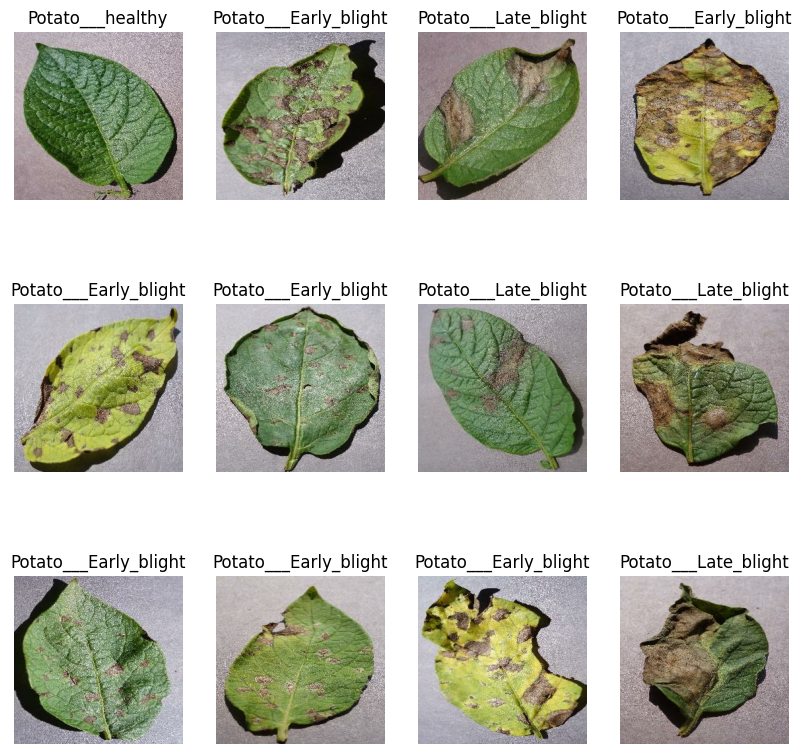

In [20]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [22]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds=dataset.take(54)
len(train_ds)

54

In [24]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [27]:
val_size=0.1
len(dataset)*val_Size

6.800000000000001

In [28]:
test_ds=test_ds.skip(6)
len(test_ds)

2

In [32]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split+val_split) ==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds =ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [34]:
len(train_ds)


54

In [35]:
len(val_ds)

6

In [36]:
len(test_ds)

8


Cache, Shuffle, and Prefetch the Dataset

In [38]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Building the Model**

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [39]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [48]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [51]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [61]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes=3

model =models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])

model.build(input_shape=input_shape)

In [63]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [64]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [65]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
54/54 [==============================] - 19s 293ms/step - loss: 0.8889 - accuracy: 0.4682 - val_loss: 0.8489 - val_accuracy: 0.5365
Epoch 2/50
54/54 [==============================] - 16s 288ms/step - loss: 0.7624 - accuracy: 0.6238 - val_loss: 0.5867 - val_accuracy: 0.7188
Epoch 3/50
54/54 [==============================] - 16s 281ms/step - loss: 0.5925 - accuracy: 0.7477 - val_loss: 0.5482 - val_accuracy: 0.7760
Epoch 4/50
54/54 [==============================] - 16s 284ms/step - loss: 0.4365 - accuracy: 0.8171 - val_loss: 0.4753 - val_accuracy: 0.8177
Epoch 5/50
54/54 [==============================] - 16s 279ms/step - loss: 0.3847 - accuracy: 0.8368 - val_loss: 0.2487 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 16s 283ms/step - loss: 0.3994 - accuracy: 0.8449 - val_loss: 0.3298 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 16s 283ms/step - loss: 0.3234 - accuracy: 0.8611 - val_loss: 0.2785 - val_accuracy: 0.8854

In [66]:
score=model.evaluate(test_ds)

8/8 [==============================] - 1s 48ms/step - loss: 0.1632 - accuracy: 0.9531


In [68]:

score

[0.1632465124130249, 0.953125]

**Plotting the Accuracy and Loss Curves**

In [69]:

history

In [70]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [71]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

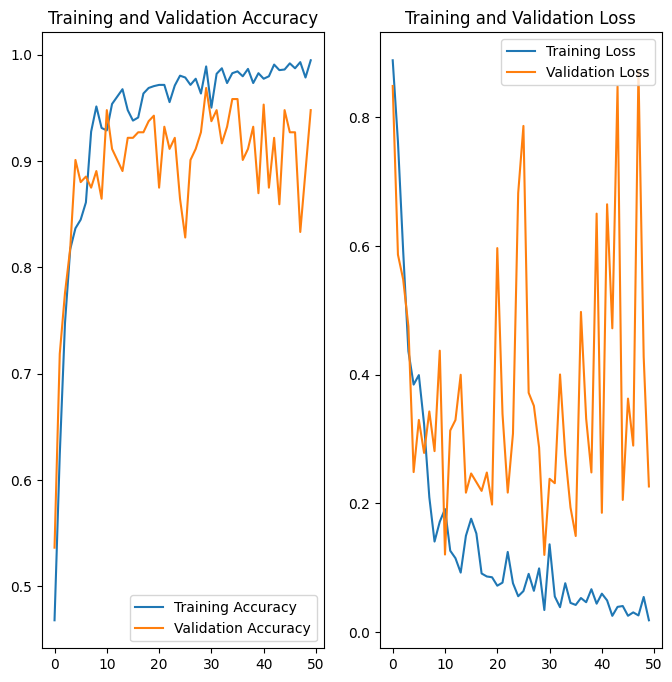

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 109ms/step
predicted label: Potato___Early_blight


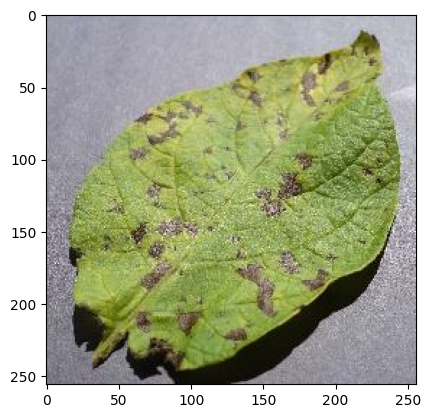

In [74]:

import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

**Write a function for inference**

In [75]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


**Now run inference on few sample images**

1/1 [==============================] - 0s 17ms/step


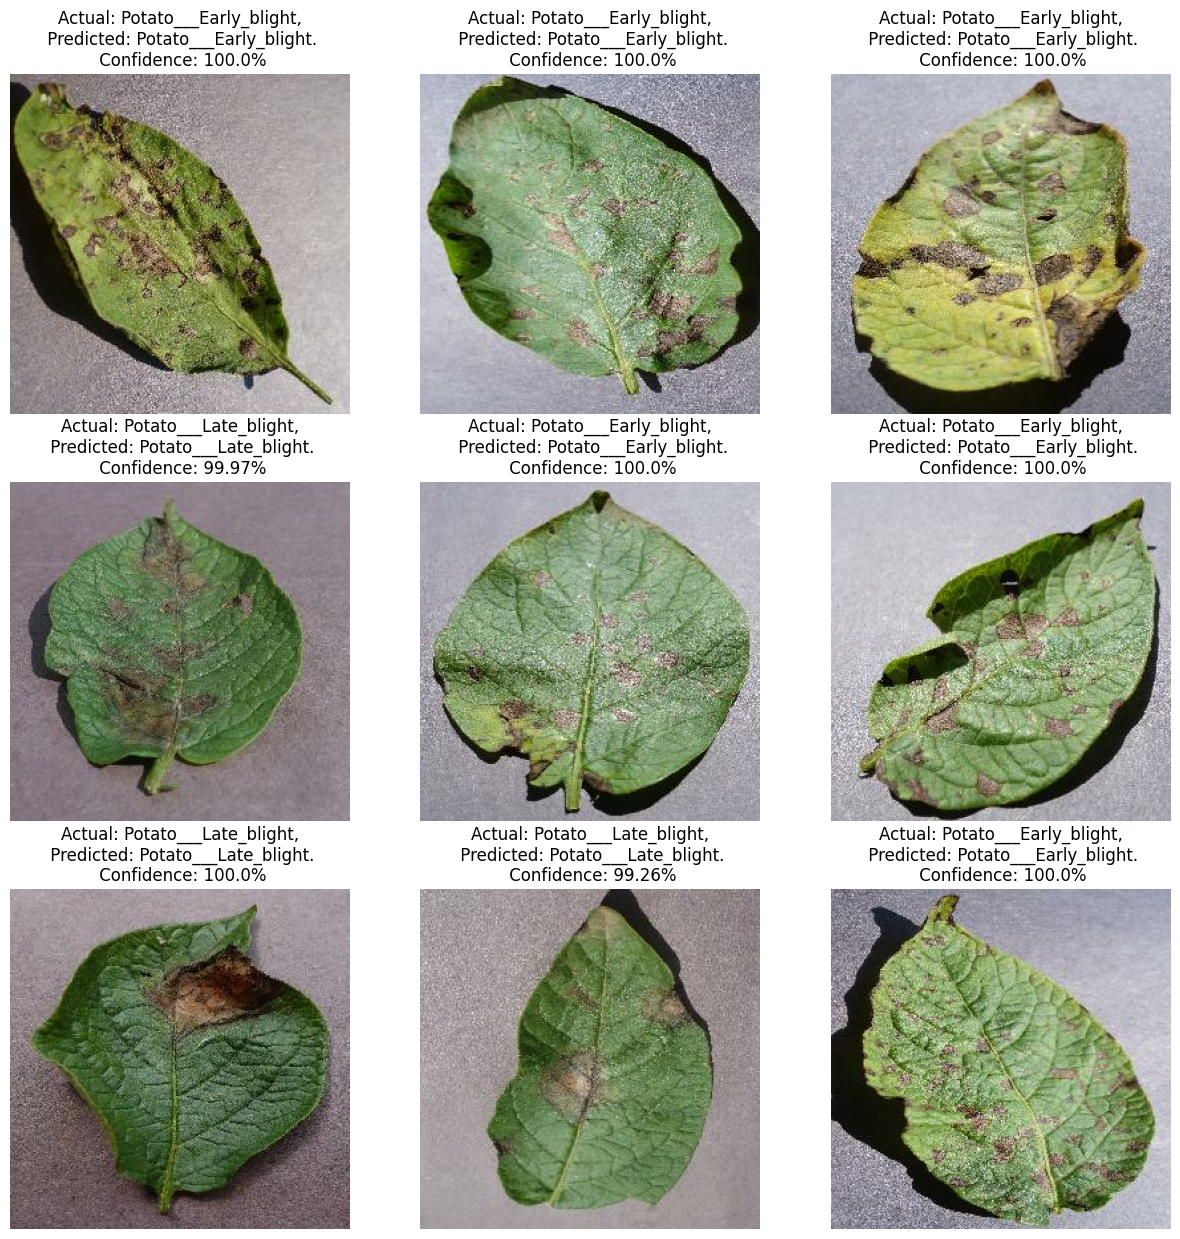

In [76]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**
Saving the Mode**l

In [78]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [79]:
model.save("../potatoes.h5")